<a href="https://colab.research.google.com/github/utkarsh01-code/Soft-Computing-Assignment/blob/main/SoftComputingQuestion1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install opencv-python

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import cv2
from PIL import Image
import io
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [4]:
train = '/content/drive/MyDrive/train-00000-of-00001-c08a401c53fe5312.parquet'
test = '/content/drive/MyDrive/test-00000-of-00001-44110b9df98c5585.parquet'
categorias = {
    0: 'Mild_Demented',
    1: 'Moderate_Demented',
    2: 'Non_Demented',
    3: 'Very_Mild_Demented'
}
data_train = pd.read_parquet(train)
data_test = pd.read_parquet(test)
data_train.head()

,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2


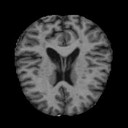

In [5]:
img_dict = data_train['image'][0]
byte_string = img_dict['bytes']
nparr = np.frombuffer(byte_string, np.uint8)
img = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)

image = Image.open(io.BytesIO(byte_string))
display(image)

In [6]:
def extraccion_y_transformacion(images_set):
    et_list_images = []
    images_bytes = images_set['image']
    for img_dict in images_bytes:
        byte_string = img_dict['bytes']
        nparr = np.frombuffer(byte_string, np.uint8)
        img = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)
        et_list_images.append(img)
    return et_list_images

def visualizar_imagenes(image_set, categorias, limit=5):
    fig, axes = plt.subplots(1, limit, figsize=(10, 5))
    image_bytes = image_set['image']

    for i, (ax, row) in enumerate(zip(axes, image_set.iterrows())):
        img_dict = row[1]['image']
        label = row[1]['label']
        name = categorias[label]

        byte_string = img_dict['bytes']
        image = Image.open(io.BytesIO(byte_string))

        ax.imshow(image, cmap='gray')
        ax.set_title(name)
        ax.axis('off')

        if i + 1 == limit:
            break

    plt.tight_layout()
    plt.show()

In [7]:
train_transformado = extraccion_y_transformacion(data_train)
test_transformado = extraccion_y_transformacion(data_test)
print(train_transformado[:1])

[array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)]


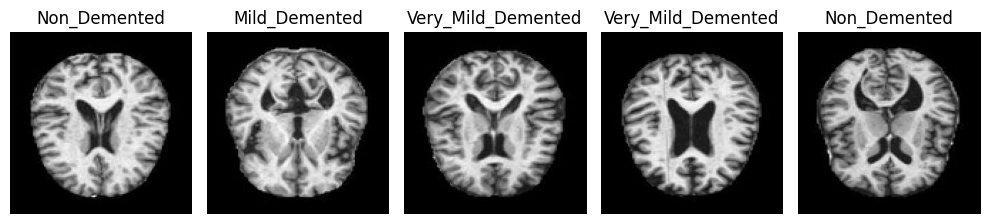

In [8]:
visualizar_imagenes(data_train, categorias, limit=5)

In [9]:
train_transformado = [np.expand_dims(img, axis=-1) for img in train_transformado] # agregar el canal de escala de grises
#test_transformado = [np.expand_dims(img, axis=-1) for img in test_transformado]
train_transformado[0].shape

(128, 128, 1)

In [10]:
class MinMaxScaler3D(MinMaxScaler):
    def fit_transform(self, X, y=None):
        x = np.reshape(X, newshape=(X.shape[0]*X.shape[1], X.shape[2]))
        return np.reshape(super().fit_transform(x, y=y), newshape=X.shape)

scaler = MinMaxScaler3D()
train_scaled = [scaler.fit_transform(X=img) for img in train_transformado]
train_scaled = np.array(train_scaled)

In [11]:
y_train = []
for label in data_train['label']:
    y_train.append(label)

y_train = np.array(y_train)
y_train = tf.one_hot(y_train.astype(np.int32), depth=4)

In [12]:
y_train

<tf.Tensor: shape=(5120, 4), dtype=float32, numpy=
array([[0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.]], dtype=float32)>

In [13]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Sequential, initializers
from sklearn.preprocessing import StandardScaler

In [14]:
model = Sequential([
    layers.Input(shape=(128,128,1)),
    layers.Conv2D(64, (5,5), activation='relu',kernel_initializer = initializers.HeNormal(seed=42), padding='same'),
    layers.MaxPool2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(len(categorias), activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='categorical_crossentropy', metrics=["acc"])

In [15]:
# prompt: Train model

model.fit(train_scaled, y_train, epochs=10)

Epoch 1/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 150s 933ms/step - acc: 0.4866 - loss: 171.7028
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 188s 847ms/step - acc: 0.4982 - loss: 1.0511
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 144s 859ms/step - acc: 0.4965 - loss: 1.0425
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 134s 836ms/step - acc: 0.4995 - loss: 1.0395
Epoch 5/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 145s 909ms/step - acc: 0.5058 - loss: 1.0330
Epoch 6/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 193s 853ms/step - acc: 0.5070 - loss: 1.0362
Epoch 7/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 143s 864ms/step - acc: 0.4769 - loss: 1.0395
Epoch 8/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 141s 856ms/step - acc: 0.4940 - loss: 1.0505
Epoch 9/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 142s 855ms/step - acc: 0.5105 - loss: 1.0277
Epoch 10/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 140s 847ms/step - acc: 0.5067 - loss: 1.0274


In [16]:
# prompt: accuracy score

# Assuming you have your model and test data prepared (test_scaled and y_test)
from sklearn.metrics import accuracy_score

# Get predictions from your model
y_pred = model.predict(train_scaled)

# Convert predicted probabilities to class labels (e.g., using argmax)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_train, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_true_labels, y_pred_labels)
print("Accuracy:", accuracy)

160/160 ━━━━━━━━━━━━━━━━━━━━ 47s 293ms/step
Accuracy: 0.501171875
